In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

from copulas.univariate import  StudentTUnivariate
from copulas.multivariate import GaussianMultivariate
from scipy.stats import t, pearsonr
import statsmodels.api as sm
import scipy as sp

### Data cleaning

In [5]:
# import csv
bid_ask_0 = pd.read_csv("./island-data-bottle-round-2/prices_round_2_day_-1.csv", sep=";")
bid_ask_1 = pd.read_csv("./island-data-bottle-round-2/prices_round_2_day_0.csv", sep=";")
bid_ask_2 = pd.read_csv("./island-data-bottle-round-2/prices_round_2_day_1.csv", sep=";")
bid_ask_0.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-1,0,PEARLS,10002,1,9996.0,2.0,9995.0,29.0,10004,2,10005.0,29.0,NaN,NaN,10003.0,0.0
1,-1,0,PINA_COLADAS,14999,38,14998.0,53.0,NaN,NaN,15001,38,15002.0,53.0,NaN,NaN,15000.0,0.0
2,-1,0,COCONUTS,7999,162,NaN,NaN,NaN,NaN,8001,55,8002.0,107.0,NaN,NaN,8000.0,0.0
3,-1,0,BANANAS,4951,1,4946.0,2.0,4945.0,29.0,4952,31,NaN,NaN,NaN,NaN,4951.5,0.0
4,-1,100,PEARLS,9996,2,9995.0,22.0,NaN,NaN,10004,2,10005.0,22.0,NaN,NaN,10000.0,4.0


In [6]:
deal_0 = pd.read_csv("./island-data-bottle-round-2/trades_round_2_day_-1_nn.csv", sep=";")
deal_1 = pd.read_csv("./island-data-bottle-round-2/trades_round_2_day_0_nn.csv", sep=";")
deal_2 = pd.read_csv("./island-data-bottle-round-2/trades_round_2_day_1_nn.csv", sep=";")
deal_0.head()

,timestamp,buyer,seller,symbol,currency,price,quantity
0,0,NaN,NaN,PEARLS,SEASHELLS,10004.0,1
1,0,NaN,NaN,BANANAS,SEASHELLS,4952.0,1
2,1100,NaN,NaN,PEARLS,SEASHELLS,9996.0,2
3,1300,NaN,NaN,BANANAS,SEASHELLS,4949.0,3
4,1600,NaN,NaN,COCONUTS,SEASHELLS,8000.0,30


In [7]:
# extract coconut and pina, day -1, day 0 as train
coconut = pd.concat([bid_ask_0[bid_ask_0['product'] == 'COCONUTS'], 
                     bid_ask_1[bid_ask_1['product'] == 'COCONUTS']], axis = 0)
pina = pd.concat([bid_ask_0[bid_ask_0['product'] == 'PINA_COLADAS'], 
                  bid_ask_1[bid_ask_1['product'] == 'PINA_COLADAS']], axis = 0)

In [8]:
coconut = coconut.reset_index(drop = True)
pina = pina.reset_index(drop = True)

In [9]:
# compute mid price
coconut['mid'] = (coconut['bid_price_1'] + coconut['ask_price_1'])/2
pina['mid'] = (pina['bid_price_1'] + pina['ask_price_1'])/2

# compute return
coconut['returns'] = coconut['mid'].pct_change().fillna(0)
pina['returns'] = pina['mid'].pct_change().fillna(0)

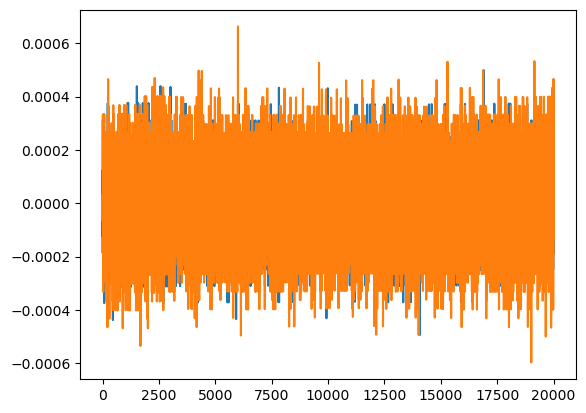

In [10]:
plt.plot(coconut.index, coconut['returns'])
plt.plot(pina.index, pina['returns'])

In [11]:
dof_1, loc_1, scale_1 = sp.stats.t.fit(coconut['returns'])
dof_2, loc_2, scale_2 = sp.stats.t.fit(pina['returns'])

### Fit Data

In [12]:
# construct data dataframe
data = pd.concat([coconut['returns'], pina['returns']], axis = 1)
data.columns = ['coconut', 'pina']

# Fit Gaussian Copula
dist = GaussianMultivariate(distribution = {"x": StudentTUnivariate,"y": StudentTUnivariate})
dist.fit(data)

# sample simulated distribution
sampled = dist.sample(len(coconut))

c:\ProgramData\Anaconda3\envs\prosperity\lib\site-packages\scipy\stats\_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\ProgramData\Anaconda3\envs\prosperity\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\Anaconda3\envs\prosperity\lib\site-packages\scipy\stats\_continuous_distns.py:5574: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
c:\ProgramData\Anaconda3\envs\prosperity\lib\site-packages\scipy\stats\_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
c:\ProgramData\Anaconda3\envs\prosperity\lib\site-packages\scipy\stats\_continuous_distns.py:5565: RuntimeWarning: divide by zero encountered in power
  return cd2*x*

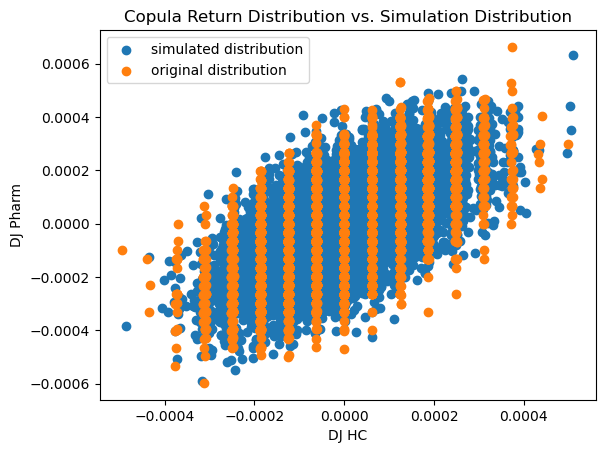

In [13]:
plt.scatter(sampled['coconut'], sampled['pina'])
plt.scatter(coconut['returns'], pina['returns'])
plt.legend(['simulated distribution', 'original distribution'])
plt.title('Copula Return Distribution vs. Simulation Distribution')
plt.xlabel('DJ HC')
plt.ylabel('DJ Pharm')
plt.savefig('original_dist_vs_simulated_dist.png', dpi=960)

In [17]:
# Identify a pair of highly correlated assets
corr, _ = pearsonr(coconut['returns'], pina['returns'])
print('Correlation:', corr)

# Collect historical data for the two assets
data = pd.concat([coconut['returns'], pina['returns']], axis=1)
data.columns = ['coconut', 'pina']
data.index = coconut.index

# determine degree of freedom
dof = np.floor((dof_1+dof_2)/2) # Degrees of freedom
rho = np.corrcoef(data, rowvar=False)[0, 1] # Correlation

# Simulate random pairs of returns using the t-copula
simulated_returns = pd.DataFrame({
    'coconut': t.ppf(sampled.iloc[:, 0], 100, loc=coconut['returns'].mean(), scale=coconut['returns'].std()),
    'pina': t.ppf(sampled.iloc[:, 1], 100, loc=pina['returns'].mean(), scale=pina['returns'].std())
})
print(data.head())

# Step 5: Calculate the spread and compare to observed spread
simulated_spread = (simulated_returns['coconut'] - simulated_returns['pina']).fillna(0)
#data['observed_spread'] = data['coconut'] - data['pina'].iloc[:, 1]
data['observed_spread'] = data['coconut'] - data['pina']

x = 0
data['signal'] = 0
for i in data.index:
    
    z_score = (data.loc[i, 'observed_spread'] - simulated_spread.mean()) / simulated_spread.std()

    if z_score > 1.68 or z_score < -1.68: # 95% confidence level
        #print('Pair trading opportunity detected!')

        # Step 6: Take positions in the two assets
        #hedge_ratio = sm.OLS(data.iloc[:, 0], data.iloc[:, 1]).fit().params[0]
        #df_1_qty = 1
        #df_2_qty = -hedge_ratio
        data.loc[i, 'signal'] = 1
        x += 1
    else:
        pass
        #print('No pair trading opportunity detected.')
print(x)


Correlation: 0.6243259132526671
    coconut      pina
0  0.000000  0.000000
1 -0.000062  0.000000
2 -0.000125 -0.000033
3  0.000125  0.000033
4 -0.000125 -0.000067
8160


Text(0, 0.5, 'Return Spread')

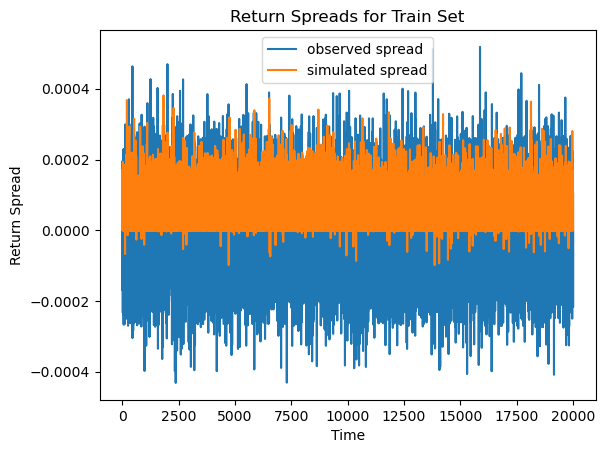

In [18]:
plt.plot(data['observed_spread'])
plt.plot(simulated_spread)
plt.legend(['observed spread', 'simulated spread'])
plt.title('Return Spreads for Train Set')
plt.xlabel('Time')
plt.ylabel('Return Spread')
#plt.savefig('return_spread_train.png', dpi=960)

Text(0, 0.5, 'Return Spread')

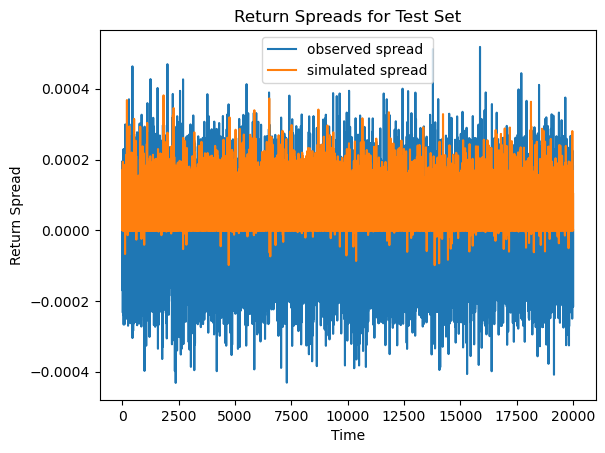

In [19]:
plt.plot(data.index, data['observed_spread'])
plt.plot(data.index, simulated_spread)
plt.legend(['observed spread', 'simulated spread'])
plt.title('Return Spreads for Test Set')
plt.xlabel('Time')
plt.ylabel('Return Spread')
#plt.savefig('return_spread_test.png', dpi=960)